# Model Training: Churn Prediction

This notebooks builds a reproducible **model** to predict `churn_value`,
using a preprocessing pipeline and evaluation metrics suitable for churn classification.

In [30]:
from pathlib import Path
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt


RANDOM_STATE = 42

## Load Cleaned Data

In [2]:
data_dir = Path().resolve().parent / "data"
raw_data_path = data_dir / "processed" / "Telco_customer_churn.xlsx"
df = pd.read_excel(raw_data_path)

In [3]:
df.head().T

,0,1,2,3,4
gender,Male,Female,Female,Female,Male
senior_citizen,No,No,No,No,No
partner,No,No,No,Yes,No
dependents,No,Yes,Yes,Yes,Yes
tenure_months,2,2,8,28,49
phone_service,Yes,Yes,Yes,Yes,Yes
multiple_lines,No,No,Yes,Yes,Yes
internet_service,DSL,Fiber optic,Fiber optic,Fiber optic,Fiber optic
online_security,Yes,No,No,No,No
online_backup,Yes,No,No,No,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   object 
 1   senior_citizen     7043 non-null   object 
 2   partner            7043 non-null   object 
 3   dependents         7043 non-null   object 
 4   tenure_months      7043 non-null   int64  
 5   phone_service      7043 non-null   object 
 6   multiple_lines     7043 non-null   object 
 7   internet_service   7043 non-null   object 
 8   online_security    7043 non-null   object 
 9   online_backup      7043 non-null   object 
 10  device_protection  7043 non-null   object 
 11  tech_support       7043 non-null   object 
 12  streaming_tv       7043 non-null   object 
 13  streaming_movies   7043 non-null   object 
 14  contract           7043 non-null   object 
 15  paperless_billing  7043 non-null   object 
 16  payment_method     7043 

## Train/Validation/Test Split

In [5]:
X = df.drop("churn_value", axis=1)
y = df.churn_value

display(X.head().T)
display(y)

,0,1,2,3,4
gender,Male,Female,Female,Female,Male
senior_citizen,No,No,No,No,No
partner,No,No,No,Yes,No
dependents,No,Yes,Yes,Yes,Yes
tenure_months,2,2,8,28,49
phone_service,Yes,Yes,Yes,Yes,Yes
multiple_lines,No,No,Yes,Yes,Yes
internet_service,DSL,Fiber optic,Fiber optic,Fiber optic,Fiber optic
online_security,Yes,No,No,No,No
online_backup,Yes,No,No,No,Yes


0       1
1       1
2       1
3       1
4       1
       ..
7038    0
7039    0
7040    0
7041    0
7042    0
Name: churn_value, Length: 7043, dtype: int64

In [6]:
X_full_train, X_test, y_full_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_full_train, y_full_train, test_size=0.2, random_state=RANDOM_STATE
)

print("Dataset shapes:")
print(f"X_full_train shape: {X_full_train.shape}")
print(f"y_full_train shape: {y_full_train.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Dataset shapes:
X_full_train shape: (5634, 20)
y_full_train shape: (5634,)
X_train shape: (4507, 20)
y_train shape: (4507,)
X_val shape: (1127, 20)
y_val shape: (1127,)
X_test shape: (1409, 20)
y_test shape: (1409,)


## Feature Selection

In [7]:
# Categorical features
categorical_features = df.select_dtypes("object").columns.tolist()
categorical_features, len(categorical_features)

(['gender',
  'senior_citizen',
  'partner',
  'dependents',
  'phone_service',
  'multiple_lines',
  'internet_service',
  'online_security',
  'online_backup',
  'device_protection',
  'tech_support',
  'streaming_tv',
  'streaming_movies',
  'contract',
  'paperless_billing',
  'payment_method'],
 16)

In [8]:
# Numerical features expect churn_value
numerical_features = (
    df.select_dtypes("number")
    .drop(columns=["churn_value"], errors="ignore")
    .columns.tolist()
)

numerical_features, len(numerical_features)

(['tenure_months', 'monthly_charges', 'total_charges', 'cltv'], 4)

### Mutual Information

In [9]:
def feature_selection(X, y, categorical_features, numerical_features, top_k=15):
    X_features = X.copy()

    # Encode categorical features
    encode = OrdinalEncoder()
    X_features[categorical_features] = encode.fit_transform(
        X_features[categorical_features]
    )

    # Discrete mask: True for categoricals, False for continuous
    discrete_mask = [True] * len(categorical_features) + [False] * len(
        numerical_features
    )

    # Calculate Mutual Information for all features
    scores = mutual_info_classif(
        X_features, y, discrete_features=discrete_mask, random_state=RANDOM_STATE
    )
    scores = pd.Series(scores, index=X_features.columns).sort_values(ascending=False)

    # Get top k features
    top_features = list(scores.index[:top_k])

    return scores, top_features

In [10]:
# Mutual Information for all categorical columns
mi_scores, top_features = feature_selection(
    X_train, y_train, categorical_features, numerical_features
)

mi_scores, top_features

(contract             0.097556
 tenure_months        0.080630
 online_security      0.068150
 tech_support         0.065462
 payment_method       0.061393
 internet_service     0.057108
 total_charges        0.050323
 online_backup        0.048643
 monthly_charges      0.048325
 device_protection    0.044722
 dependents           0.035386
 streaming_movies     0.035003
 streaming_tv         0.034595
 paperless_billing    0.021360
 senior_citizen       0.010461
 partner              0.010090
 cltv                 0.004774
 multiple_lines       0.001292
 phone_service        0.000012
 gender               0.000002
 dtype: float64,
 ['contract',
  'tenure_months',
  'online_security',
  'tech_support',
  'payment_method',
  'internet_service',
  'total_charges',
  'online_backup',
  'monthly_charges',
  'device_protection',
  'dependents',
  'streaming_movies',
  'streaming_tv',
  'paperless_billing',
  'senior_citizen'])

In [12]:
X_train_fs = X_train[top_features]
X_val_fs = X_val[top_features]
X_test_fs = X_test[top_features]

numerical_features = X_train_fs.select_dtypes("number").columns.tolist()
categorical_features = X_train_fs.select_dtypes("object").columns.tolist()

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

X_train_fs.head().T

Numerical features: ['tenure_months', 'total_charges', 'monthly_charges']
Categorical features: ['contract', 'online_security', 'tech_support', 'payment_method', 'internet_service', 'online_backup', 'device_protection', 'dependents', 'streaming_movies', 'streaming_tv', 'paperless_billing', 'senior_citizen']


,4806,3409,3339,3541,4009
contract,Month-to-month,Month-to-month,Month-to-month,Two year,Two year
tenure_months,14,40,17,72,6
online_security,No,No,No,Yes,Yes
tech_support,No,Yes,No,Yes,Yes
payment_method,Electronic check,Credit card (automatic),Electronic check,Credit card (automatic),Mailed check
internet_service,Fiber optic,Fiber optic,Fiber optic,Fiber optic,DSL
total_charges,1337.45,3126.85,1329.15,8124.2,348.8
online_backup,No,No,Yes,Yes,Yes
monthly_charges,92.9,78.85,83.55,113.65,63.4
device_protection,No,No,No,Yes,Yes


## Preprocessing Pipeline

In [18]:
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

## Baseline Model

### Pipeline

In [19]:
baseline_classifier = LogisticRegression(
    max_iter=10000,
    class_weight="balanced",  # To account for class imbalance
    random_state=RANDOM_STATE,
)

In [26]:
baseline_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", baseline_classifier),
    ]
)

### Train

In [27]:
baseline_pipeline.fit(X_train_fs, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Evaluate on validation set

In [29]:
y_val_proba = baseline_pipeline.predict_proba(X_val_fs)[:, 1]
y_val_pred = baseline_pipeline.predict(X_val_fs)

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Precision:", precision_score(y_val, y_val_pred))
print("Validation Recall:", recall_score(y_val, y_val_pred))
print("Validation F1:", f1_score(y_val, y_val_pred))
print("Validation ROC AUC:", roc_auc_score(y_val, y_val_proba))

print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

Validation Accuracy: 0.7497781721384206
Validation Precision: 0.5
Validation Recall: 0.7836879432624113
Validation F1: 0.6104972375690608
Validation ROC AUC: 0.8552163330395737

Confusion Matrix:
 [[624 221]
 [ 61 221]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.74      0.82       845
           1       0.50      0.78      0.61       282

    accuracy                           0.75      1127
   macro avg       0.71      0.76      0.71      1127
weighted avg       0.81      0.75      0.76      1127



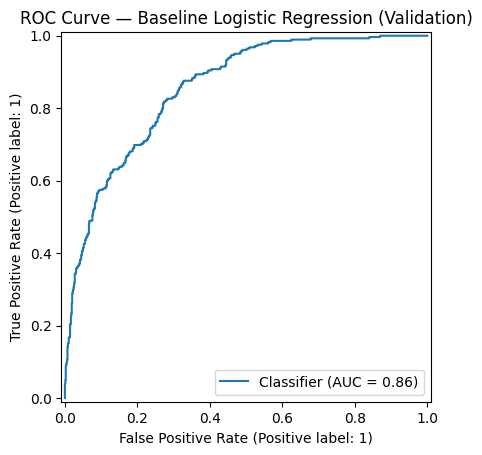

In [31]:
RocCurveDisplay.from_predictions(y_val, y_val_proba)
plt.title("ROC Curve — Baseline Logistic Regression (Validation)")
plt.show()

## Tuning

## Evaluation

## Save Final Model